In [2]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../preprocessing/Artifact_Removal/Batch_ArtifactFilter_Epoch.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
import os
import seaborn as sns
import mne
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

from sklearn import preprocessing
from mne.decoding import Vectorizer
from sklearn.pipeline import make_pipeline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.


In [3]:
path = 'F:\stim_code_epochs'
epoch_files = os.listdir(path)

In [4]:
np.random.seed(42)
n = np.random.randint(0,len(epoch_files))
print(n)

102


In [5]:
epoch = mne.read_epochs(os.path.join(path, epoch_files[6]), preload = True)

Reading F:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [6]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [7]:
# reduce dimensions of n_times to a point for each band.
montage = mne.channels.read_montage(kind = 'ANT_DukeWaveGuard_128_electrode_montages_updated_V4')
epoch.set_montage(montage);
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);

The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.


<ipython-input-7-20254dd9ff05>:3: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.
  epoch.set_montage(montage);


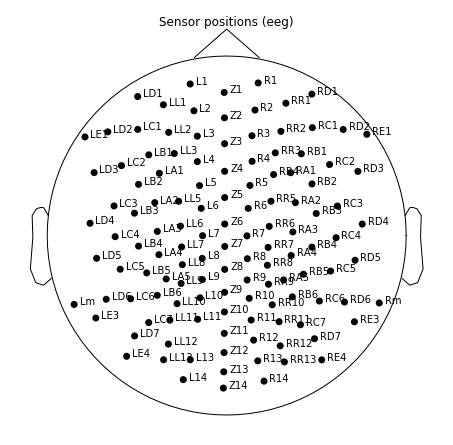

In [8]:
epoch.plot_sensors(show_names=True);

In [9]:
data = epoch.get_data()

In [10]:
new_events = convert_epoch_events_to_stim_combinations(epoch)

In [11]:
epoch.events = new_events

In [12]:
# create arrays based on audio and visual
audio_epochs = []
visual_epochs = []

for i in range(len(epoch)): 
#     print(i)
    if epoch[i].events[:,-1][0] <700:
#         print("audio")
        audio_epochs.append(epoch[i].get_data())
    else:
#         print("visual")
        visual_epochs.append(epoch[i].get_data())

In [ ]:
pipeline = make_pipeline(Vectorizer(), StandardScaler())
scaled_audio_data = pipeline.fit_transform(audio_epochs)
scaled_visual_data = pipeline.fit_transform(visual_epochs)

In [ ]:
vectorizer = make_pipeline(Vectorizer())
vectorized_audio_data = vectorizer.fit_transform(audio_epochs)
vectorized_visual_data = vectorizer.fit_transform(visual_epochs)


In [ ]:
scaled_audio_data = preprocessing.scale(vectorized_audio_data)
scaled_visual_data = preprocessing.scale(vectorized_visual_data)

In [ ]:
audio_variance = []
for data in scaled_audio_data:
#     print(data)
    audio_variance.append(np.var(data))
visual_variance = []
for data in scaled_visual_data:
    visual_variance.append(np.var(data))

In [ ]:
all_variance = []


In [ ]:
np.array(visual_variance)

In [ ]:
np.array(audio_variance).shape

In [ ]:
epoch.filter

In [14]:
def get_audio_visual_labels(epoch_object):
    events = epoch_object.events[:,-1]
    labels = []
    for event in events:
        if event < 700:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels) 

### extracting frequency bands

In [15]:
def get_frequency_band(band, epoch_object):
    """
    Description:
        returns an epoch object with a filtered frequency band
    
    Variables: 
        band : 
            'Theta':(4,7),
            'Alpha':(8,12),
            'Beta':(13,25),
            'Gamma':(30,45)
        epoch_object: mne.epoch
    -----
    returns: epoch object
    
    """
    iter_freqs = {
        'Theta':(4,7),
        'Alpha':(8,12),
        'Beta':(13,25),
        'Gamma':(30,45)
    }
    copy_epoch = epoch_object.copy()
    copy_epoch.filter(l_freq= iter_freqs[band][0],
                    h_freq = iter_freqs[band][1])
    
    return copy_epoch


In [16]:
gamma_epoch = get_frequency_band('Gamma', epoch)
theta_epoch = get_frequency_band('Theta', epoch)


Setting up band-pass filter from 30 - 45 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 113 samples (0.441 sec) selected
Setting up band-pass filter from 4 - 7 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 423 samples (1.652 sec) selected


In [34]:
beta_epoch = get_frequency_band('Beta', epoch)
alpha_epoch = get_frequency_band('Alpha',epoch)

Setting up band-pass filter from 13 - 25 Hz
l_trans_bandwidth chosen to be 3.2 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 261 samples (1.020 sec) selected
Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 423 samples (1.652 sec) selected


In [18]:
def variance_of_epochs(epoch_object):
    pipeline = make_pipeline(Vectorizer(), StandardScaler())
    
    scaled_epoch_data = pipeline.fit_transform(epoch_object.get_data())
    
    variance_epochs = []
    for data in scaled_epoch_data:
        variance_epochs.append(np.var(data))
    
    return np.array(variance_epochs)

In [38]:
variance_gamma_epochs = variance_of_epochs(gamma_epoch)
variance_theta_epochs = variance_of_epochs(theta_epoch)
variance_beta_epochs = variance_of_epochs(beta_epoch)
variance_alpha_epochs = variance_of_epochs(alpha_epoch)

In [39]:
variance_gamma_epochs = variance_gamma_epochs[:-1]
variance_theta_epochs = variance_theta_epochs[:-1]
variance_beta_epochs = variance_beta_epochs[:-1]
variance_alpha_epochs = variance_alpha_epochs[:-1]

In [ ]:
variance_gamma_epochs.shape

In [21]:
labels = get_audio_visual_labels(gamma_epoch)

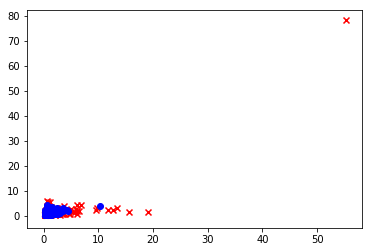

In [41]:
plt.scatter(variance_gamma_epochs[labels == 0], 
            variance_theta_epochs[labels == 0], c = 'red', marker = 'x');
plt.scatter(variance_gamma_epochs[labels == 1], 
            variance_theta_epochs[labels == 1], c = 'blue', marker = 'o');


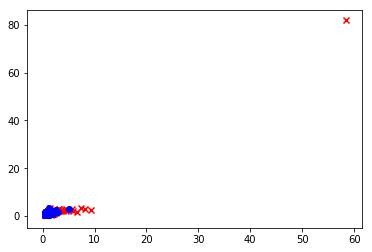

In [42]:
plt.scatter(variance_beta_epochs[labels == 0], 
            variance_alpha_epochs[labels == 0], c = 'red', marker = 'x');
plt.scatter(variance_beta_epochs[labels == 1], 
            variance_alpha_epochs[labels == 1], c = 'blue', marker = 'o');


In [ ]:
epoch.get_data().shape

In [13]:
new_events.shape

(939, 3)